<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #2. Optional part
## <center> Implementation of the decision tree algorithm
    
#  <center>  <font color = 'red'> Warning! </font>This is a very useful but ungraded assignment

In [104]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
from scipy.stats import entropy

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [5]:
RANDOM_STATE = 17

**Implement the class `DecisionTree`**
**Specification:**
- the class is inherited from `sklearn.BaseEstimator`;
- class constructor has the following parameters: 
    `max_depth` - maximum depth of the tree (`numpy.inf` by default); 
    `min_samples_split` - the minimum number of instances in a node for a splitting to be done (2 by default); 
    `criterion` - split criterion ('gini' or 'entropy' for classification, 'variance' or 'mad_median' for regression; 'gini' by default);
    
    A functional to be maximized to find an optimal partition at a given node has the form
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts 
    with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
    For classification: let $p_i$ be the fraction of the instances of the $i$-th class in the dataset $X$.
    
    'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    For regression: $y_j = y(x_j)$ - is a target for an instance $x_j$, $y = (y_1, \dots, y_{|X|})$ - is a target vector.
    
    'variance': Variance (mean quadratic deviation from average) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Mean deviation from the median $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

In [6]:
def entropy1(y):    
    e = 0
    for v in y:
        e += -v *np.log2(v)

def gini(y):
    sum = 0
    for i in y:
        sum += i**2
    return 1 - sum    

def variance(y):
     return np.var(y) 

def mad_median(y):
    pass

The `Node` class implements a node in the decision tree.

In [94]:
class Node():

    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

    def __str__(self):
        return 'feature index = {0},threshold ={1},[{2},{3}]'.format(self.feature_idx, self.threshold, len((self.left)), len((self.right)))

Let's determine the function for calculating a prediction in a leaf. For regression, let's take the mean for all values in a leaf, for classification - the most popular class in leaf.

In [114]:
class DecisionTree(BaseEstimator):

    def __str__(self):

        if self.left_child is None:
            left = ""
        else:
            left = "\r\n" + str(self.left_child)

        if self.right_child is None:
            right = ""
        else:
            right = "\r\n" + str(self.right_child)

        if self.root_node is None:
            current = ""
        else:
            current = str(self.root_node)
        return current + left + right

    def __init__(self, max_depth=np.inf, min_samples_split=2,
                 criterion='gini', debug=False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        if criterion == 'gini':
            self.crit = gini
        else:
            self.crit = entropy

        self.left_child = None
        self.right_child = None
        self.root_node = None
        self.debug = debug


    def fit(self, X, y):
        global node_counter

        if len(y) < self.min_samples_split:
            self.root_node = Node(-1, -1, 'leaf', y, [0])
            self.root_node.counter = node_counter
            node_counter += 1
            self.right_child = None
            self.left_child = None
            return self

        max_q = float("-inf")
        best_split_value = None
        best_feature = None

        for f in range(X.shape[1]):
            x_col = X[:, f]
            splits = self._find_splits(x_col)

            for spl in splits:

                # разбиваю данные по нацлучшему критерию
                q, _, _ = self._regression_var_criterion(X, f, y, spl)
                if q > max_q:
                    max_q = q
                    best_feature = f
                    best_split_value = spl

        if best_feature is None:
            return None

        X_left, X_right, y_l, y_r = self._get_data_split(X, y, best_feature, best_split_value)

        assert X_left is not None
        assert X_right is not None

        if self.max_depth == 0:
            self.root_node = Node(best_feature, best_split_value, 'leaf', y_l, y_r)
            self.root_node.counter = node_counter
            node_counter += 1
            self.left_child = None
            self.right_child = None
            return self

        new_depth = self.max_depth
        if new_depth != np.inf:
            new_depth -= 1

        if self.debug:
            print("call left branch with X_left.shape = {0}, len(y_l) = {1}".format(X_left.shape, len(y_l)))

        left_tree = DecisionTree(max_depth=new_depth, min_samples_split=self.min_samples_split,
                                 criterion=self.criterion, debug=self.debug)
        self.left_child = left_tree.fit(X_left, y_l)

        if self.debug:
            print("call right branch with X_right.shape = {0}, len(y_r) = {1}".format(X_right.shape, len(y_r)))

        right_tree = DecisionTree(max_depth=new_depth, min_samples_split=self.min_samples_split,
                                  criterion=self.criterion, debug=self.debug)
        self.right_child = right_tree.fit(X_right, y_r)

        self.root_node = Node(best_feature, best_split_value, str(best_feature), y_l, y_r)

        return self

    def predict(self, X):

        predictions = []
        for x in X:

            cur_tree = self
            leaf = cur_tree.root_node
            while cur_tree is not None:

                leaf = cur_tree.root_node

                assert leaf is not None, "leaf.root_node is not None"

                if x[cur_tree.root_node.feature_idx] < cur_tree.root_node.threshold:
                    cur_tree = cur_tree.left_child
                else:
                    cur_tree = cur_tree.right_child

            assert leaf is not None, "leaf is not None"
#            assert leaf.labels == 'leaf', "leaf.labels =='leaf'"

            if isinstance(x, pd.DataFrame):
                type = X.dtypes[leaf.feature_idx]
                if type == 'object':
                    predictions.append(self.most_frequent(np.append(leaf.left, leaf.right)))
                else:
                    predictions.append(np.mean(np.append(leaf.left, leaf.right)))
            else:
                predictions.append(self._most_frequent(list(np.append(leaf.left, leaf.right))))
        return predictions

    def predict_leaf_number(self, x):
        predictions = []

        cur_tree = self
        leaf = cur_tree.root_node
        while cur_tree is not None:

            leaf = cur_tree.root_node

            assert leaf is not None, "leaf.root_node is not None"

            if x[cur_tree.root_node.feature_idx] < cur_tree.root_node.threshold:
                cur_tree = cur_tree.left_child
            else:
                cur_tree = cur_tree.right_child

        assert leaf is not None, "leaf is not None"
        assert leaf.labels == 'leaf', "leaf.labels =='leaf'"
        assert leaf.counter >= 0 , "leaf.counter >= 0"
        return leaf.counter



    def predict_proba(self, X):
        K = self.count_leafs()
        result = []
        i = 0
        for x in X:
            num = self.predict_leaf_number(x)
            t = np.zeros(K)
            t[num] = 1
            result.append(t)
        return  np.reshape(result,(X.shape[0],K))



    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _most_frequent(self, lst):
        return max(set(lst), key=lst.count)

    def _regression_var_criterion(self, X, feature, y, t):
        x_col_values = X[:, feature]

        assert X.shape[0] == len(x_col_values), "X.shape[0] == len(x_col_values)"
        assert X.shape[0] == len(y), "X.shape[0] == len(y)"
        # print('feature = {0}, X.shape[1] = {1}'.format(feature,X.shape[1]))
        y_l = [y[i] for i, val in enumerate(x_col_values) if val < t]
        y_r = [y[i] for i, val in enumerate(x_col_values) if val >= t]
        q = np.var(y) - len(y_l) / len(y) * self.crit(y_l) - len(y_r) / len(y) * self.crit(y_r)

        assert len(y_l) + len(y_r) == len(y)
        assert len(y_l) != 0 and len(y_r) != 0, "len(y_l) == 0 or len(y_r) == 0"

        return q, y_l, y_r

    def _get_data_split(self, X, y, feature, threshold):

        x_col_values = X[:, feature]  #
        assert X.shape[0] == len(x_col_values), "X.shape[0] == len(x_col_values)"
        assert X.shape[0] == len(y), "X.shape[0] == len(y)"
        # print('feature = {0}, X.shape[1] = {1}'.format(feature,X.shape[1]))
        y_l = [y[i] for i, val in enumerate(x_col_values) if val < threshold]
        y_r = [y[i] for i, val in enumerate(x_col_values) if val >= threshold]
        X_l = X[X[:, feature] < threshold]
        X_r = X[X[:, feature] >= threshold]

        assert len(y_l) + len(y_r) == len(y), "len(y_l) + len(y_r) == len(y)"
        assert X_l.shape[0] + X_r.shape[0] == X.shape[0], "X_l.shape[0] + X_r.shape[0] == X.shape[0]"
        return X_l, X_r, y_l, y_r

    def count_leafs(self):
        if self.root_node.labels == 'leaf':
            return 1
        else:
            sum = 0
            if self.left_child is not None:
                sum += self.left_child.count_leafs()
            if self.right_child is not None:
                sum += self.right_child.count_leafs()
            return sum

## Testing the implemented algorithm

### Classification

Download the dataset `digits` using the method `load_digits`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, and `random_state=17`. Try to train shallow decision trees and make sure that gini and entropy criteria return different results.

In [102]:
X,y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=17)


Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use range(3, 11), for criterion use {'gini', 'entropy'}. Quality measure is `scoring`='accuracy'.

In [115]:
tree_params = {'max_depth': list(range(3, 11)),'criterion': ['gini']}
tree_grid = GridSearchCV(DecisionTree(), tree_params, cv=5, scoring='accuracy')
tree_grid.fit(X_train,y_train)
print('fit done')

fit done


Draw the plot of the mean quality measure `accuracy` for criteria `gini` and `entropy` depending on `max_depth`.

{'best_estimator_': DecisionTree(criterion='gini', debug=False, max_depth=4, min_samples_split=2),
 'best_index_': 1,
 'best_params_': {'criterion': 'gini', 'max_depth': 4},
 'best_score_': 0.08698677800974251,
 'cv': 5,
 'cv_results_': {'mean_fit_time': array([ 4.87908783,  5.99319925,  7.43594346,  8.36003594,  9.37113705,
       10.17541742, 12.63246307, 12.81308126]),
                 'mean_score_time': array([0.17261734, 0.16041598, 0.16981702, 0.16401634, 0.16021595,
       0.15521545, 0.16521654, 0.16601653]),
                 'mean_test_score': array([0.08350731, 0.08698678, 0.08698678, 0.08698678, 0.08629088,
       0.08629088, 0.08629088, 0.08698678]),
                 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                   'gini'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
                 'param_max_depth': masked_array(data=[3, 4, 5, 

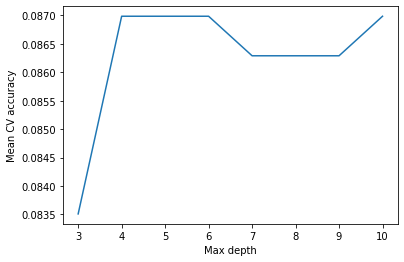

In [107]:
from pprint import pprint
pprint(vars(tree_grid))

plt.plot(tree_params['max_depth'], 
         tree_grid.cv_results_['mean_test_score'])
plt.xlabel('Max depth')
plt.ylabel('Mean CV accuracy');

**1. Choose all correct statements:**
1. Optimal value of the `max_depth` parameter is on the interval [4, 9] for both criteria.
2. Created plots have no intersection on the interval [3, 10]
3. Created plots intersect each other only once on the interval [3, 10].
4. The best quality for `max_depth` on the interval [3, 10] is reached using `gini` criterion .
5. Accuracy is strictly increasing at least for one of the criteria, when `max_depth` is also increasing on the interval [3, 10]

**2. What are the optimal values for max_depth and criterion parameters?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Train decision tree on `(X_train, y_train)` using the optimal values of `max_depth` and `criterion`. Compute class probabilities for `X_test`.

In [111]:
dt = DecisionTree(max_depth = 8,criterion = 'entropy')
tree = dt.fit(X_train,y_train)

Using the given matrix, compute the mean class probabilities for all instances in `X_test`.

In [110]:
print(tree.predict_proba(X_test))

None


**3. What is the maximum probability in a resulted vector?**
1. 0.127
2. 0.118
3. 1.0
4. 0.09

## Regression

Download the dataset `boston` using the method `load_boston`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, `random_state=17`. Try to train shallow regression decision trees and make sure that `variance` and `mad_median` criteria return different results.

In [11]:
# You code here

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use `range(2, 9)`, for `criterion` use {'variance', 'mad_median'}. Quality measure is `scoring`='neg_mean_squared_error'.

In [12]:
# You code here

Draw the plot of the mean quality measure `neg_mean_squared_error` for criteria `variance` and `mad_median` depending on `max_depth`.

In [13]:
# You code here

**4. Choose all correct statements:**
1. Created plots have no intersection on the interval [2, 8].
2. Created plots intersect each other only once on the interval [2, 8].
3. Optimal value of the `max_depth` for each of the criteria is on the border of the interval [2, 8].
4. The best quality at `max_depth` on the interval [2, 8] is reached using `mad_median` criterion.

**5. What are the optimal values for `max_depth` and `criterion` parameters?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'.